In [1]:
from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
import emcee
import corner
from Corrfunc.theory.wp import wp
import MCMC_data_file
from numpy.linalg import inv
import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import MCMC_data_file, zehavi_data_file_20, guo_data_file, mock_data, mock_data_2
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma
from scipy.stats import chisquare

In [2]:
fname = "lin_test_nong.h5"

In [19]:
files = [fname]
#files = [fname4,fname5]
s = []
log_prob_s = []
wps = []
for f in files: 
    reader = emcee.backends.HDFBackend(f, read_only=True)
    s.append(reader.get_chain(discard=0, flat=False, thin=1))
    log_prob_s.append(reader.get_log_prob(discard=0, flat=False, thin=1))
    wps.append(reader.get_blobs(discard=0))
print(reader.iteration)

10000


In [20]:
if len(files)>1:
    print('greater')
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wps[0]
    for i in range(len(files)):
        if i+1 < len(s):
            samples = np.concatenate((samples,s[i+1]))
            log_prob_samples = np.concatenate((log_prob_samples,log_prob_s[i+1]))
            wp_samples = np.concatenate((wp_samples,wps[i+1]))
else:
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wps[0]
min_chi2_loc = np.where(-2*log_prob_samples==(-2*log_prob_samples.max()))
best_wp = wp_samples[min_chi2_loc][0]
best_chi2 = (-2*log_prob_samples[min_chi2_loc])[0]

In [25]:
####calculate chi2 per degree of freedom####
deg_of_frdm = 19#16
chi_per_deg = -2.0*log_prob_samples/deg_of_frdm
print("chi2 per dof:", chi_per_deg.min())
#####randomly select 20 sets of parameters with chi2 per dof less than slightly greater than chi/deg min ####
row,col = np.where(chi_per_deg<1e10)
param_string_sampling = samples[row,col][np.random.choice(samples[row,col].shape[0],10,replace=False)]
param_sampling = []
for i in param_string_sampling:
    param_sampling.append(list(np.array(i)))

chi2 per dof: 3.294835054247781


In [26]:
wp_ng_vals = mock_data.get_wp()
bin_edges = mock_data.get_bin_edges()
cov_matrix = mock_data.get_cov()
err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
print(len(wp_ng_vals))

20


In [27]:
def pow_law(params):
    ro,g = params
    #g = 1.8
    #ro = 5.8
    rp = (bin_edges[1:]+bin_edges[:-1])/2.
    model = rp*(rp/ro)**(-g)*gamma(0.5)*gamma((g-1)/2)/gamma(g/2)
    return model

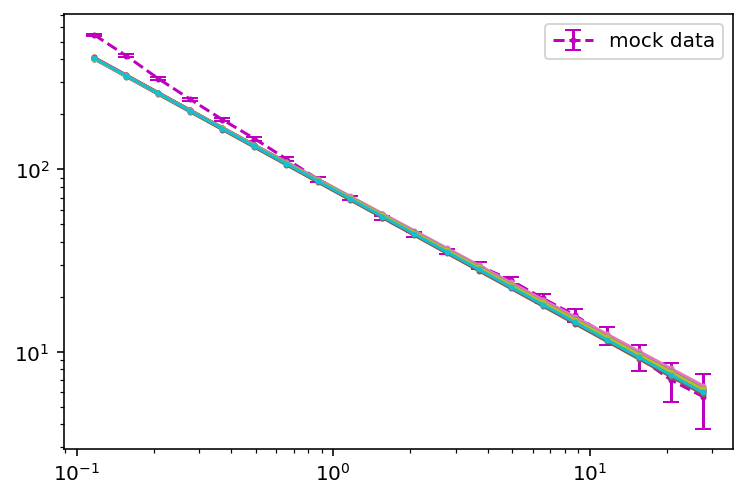

In [37]:
plt.errorbar(bin_cen,wp_ng_vals[0:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',
             markersize=2,capsize=4,label='mock data',linestyle='--',color='m')
for i in range(10):
    plt.errorbar(bin_cen,pow_law(param_sampling[i]),fmt='o',markersize=2,capsize=4,linestyle='-')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()